In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip,  RandomBrightnessContrast
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Bidirectional, Activation, MaxPool2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D,ConvLSTM2D,LSTM,GlobalAveragePooling2D, Reshape, Dense, Multiply, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate,TimeDistributed, Add,Multiply,concatenate
from keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121, MobileNetV2,ResNet50,VGG16,VGG19, NASNetLarge,EfficientNetB7,ResNet50V2,EfficientNetV2S, EfficientNetV2M,EfficientNetV2L,InceptionV3
from tensorflow.keras.metrics import Recall, Precision, Accuracy, MeanIoU
from tensorflow.keras import backend as K
#from keras.layers.core import Dense, Dropout, Activation
from keras.regularizers import l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + smooth) / (union + smooth)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
  alpha=0.25
  gamma=2
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

  y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
  logits = tf.math.log(y_pred / (1 - y_pred))
  loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
  # or reduce_sum and/or axis=-1
  return tf.reduce_mean(loss)

In [ ]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS=3
EPOCHS = 100
BATCH = 4
LR = 0.0001
shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
#PATH = "/content/drive/MyDrive/Fydp/DRIVE/training"
PATH = "/content/drive/MyDrive/NewDrive/DRIVE_COPY/training"

def create_dir(path):
  """ Create a directory. """
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
# 1. Load the dataset
# 2. Use the albumentations library to augment the dataset.

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import CenterCrop, RandomRotate90, RGBShift,ShiftScaleRotate, GridDistortion,RandomGamma, HorizontalFlip,RandomBrightnessContrast, RandomBrightness, VerticalFlip, Transpose, Compose, HueSaturationValue, RandomContrast
from albumentations.augmentations.transforms import CLAHE, GaussNoise, FancyPCA

def load_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "1st_manual/*")))
    return images, masks

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augment_data(images, masks, save_path, augment=True):
  H = 256
  W = 256

  for x, y in tqdm(zip(images, masks), total=len(images)):
    name = x.split("/")[-1].split(".")
    """ Extracting the name and extension of the image and the mask. """
    image_name = name[0]
    image_extn = name[1]

    name = y.split("/")[-1].split(".")
    mask_name = name[0]
    mask_extn = name[1]

    """ Reading image and mask. """
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_COLOR)

    """ Augmentation """
    if augment == True:
      #aug = CenterCrop(200, 200, p=1.0)
      #augmented = aug(image=x, mask=y)
      #x1 = augmented["image"]
      #y1 = augmented["mask"]

      aug = RandomRotate90(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented['image']
      y2 = augmented['mask']

      aug = RandomRotate90(p=0.5)
      augmented = aug(image=x, mask=y)
      x3 = augmented['image']
      y3 = augmented['mask']

      aug = GridDistortion(p=1.0)
      augmented = aug(image=x, mask=y)
      x4 = augmented['image']
      y4 = augmented['mask']

      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x5 = augmented['image']
      y5 = augmented['mask']

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x6 = augmented['image']
      y6 = augmented['mask']

      aug = Transpose(p=1.0)
      augmented = aug(image=x, mask=y)
      x7 = augmented['image']
      y7 = augmented['mask']

      aug = Compose([VerticalFlip(p=0.5),RandomRotate90(p=0.5)])
      augmented = aug(image=x, mask=y)
      x8 = augmented['image']
      y8 = augmented['mask']

      aug = RandomBrightnessContrast(p=1)
      augmented = aug(image=x, mask=y)
      x9 = augmented['image']
      y9 = augmented['mask']

      aug = RandomGamma(p=1)
      augmented = aug(image=x, mask=y)
      x10 = augmented['image']
      y10 = augmented['mask']

      aug = HueSaturationValue(p=1)
      augmented = aug(image=x, mask=y)
      x11 = augmented['image']
      y11 = augmented['mask']

      aug = RGBShift(p=1)
      augmented = aug(image=x, mask=y)
      x12 = augmented['image']
      y12 = augmented['mask']

      aug = RandomBrightness(p=1)
      augmented = aug(image=x, mask=y)
      x13 = augmented['image']
      y13 = augmented['mask']

      aug = RandomContrast(p=1)
      augmented = aug(image=x, mask=y)
      x14 = augmented['image']
      y14 = augmented['mask']

      aug = ShiftScaleRotate(p=0.5)
      augmented = aug(image=x, mask=y)
      x15 = augmented['image']
      y15 = augmented['mask']

      aug = Compose([VerticalFlip(p=0.7),RandomBrightness(p=0.5), RandomGamma(p=0.5)])
      augmented = aug(image=x, mask=y)
      x16 = augmented['image']
      y16 = augmented['mask']

      clip_limit=6.0
      aug = CLAHE(clip_limit, p=1.0)
      augmented = aug(image=x, mask=y)
      x17 = augmented['image']
      y17 = augmented['mask']

      alpha=1.0
      aug = FancyPCA(alpha, p=1.0)
      augmented = aug(image=x, mask=y)
      x18 = augmented['image']
      y18 = augmented['mask']

      var_limit=(10.0, 50.0)
      mean=-50
      aug = GaussNoise(var_limit, mean, p=1.0)
      augmented = aug(image=x, mask=y)
      x18 = augmented['image']
      y18 = augmented['mask']

      clip_limit=5.0
      aug = CLAHE(clip_limit, p=1.0)
      augmented = aug(image=x, mask=y)
      x19 = augmented['image']
      y19 = augmented['mask']

      aug = HueSaturationValue(p=0.5)
      augmented = aug(image=x, mask=y)
      x20 = augmented['image']
      y20 = augmented['mask']

      aug = RandomBrightnessContrast(p=0.7)
      augmented = aug(image=x, mask=y)
      x21 = augmented['image']
      y21 = augmented['mask']

      aug = RandomGamma(p=0.5)
      augmented = aug(image=x, mask=y)
      x22 = augmented['image']
      y22 = augmented['mask']


      save_images = [x, x2, x3, x4, x5, x6, x7, x8, x9, x10, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22]
      save_masks =  [y, y2, y3, y4, y5, y6, y7, y8, y9, y10, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22]

    else:
      save_images = [x]
      save_masks = [y]

    """ Saving the image and mask. """
    idx = 0
    for i, m in zip(save_images, save_masks):
      i = cv2.resize(i, (W, H))
      m = cv2.resize(m, (W, H))

      if len(images) == 1:
        tmp_img_name = f"{image_name}.{image_extn}"
        tmp_mask_name = f"{mask_name}.{mask_extn}"
      else:
        tmp_img_name = f"{image_name}_{idx}.{image_extn}"
        tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

      image_path = os.path.join(save_path, "images", tmp_img_name)
      mask_path = os.path.join(save_path, "masks", tmp_mask_name)

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)

      idx += 1

if __name__ == "__main__":
  """ Loading original images and masks. """
  #path = "/content/drive/MyDrive/Fydp/DRIVE/training"
  path = "/content/drive/MyDrive/NewDrive/DRIVE_COPY/training"
  images, masks = load_data(path)
  print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

  """ Creating folders. """
  create_dir("new_data/images")
  create_dir("new_data/masks")

  """ Applying data augmentation. """
  augment_data(images, masks, "new_data", augment=True)

  """ Loading augmented images and masks. """
  images, masks = load_data("new_data/")
  print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")

Original Images: 20 - Original Masks: 20


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

Augmented Images: 420 - Augmented Masks: 0


In [ ]:
def load_data(path, split=0.1):
  images = sorted(glob(os.path.join(path, "/content/new_data/images/*.tif")))
  masks = sorted(glob(os.path.join(path, "/content/new_data/masks/*.png")))

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# # New preprocessing code # #

def read_image(x):
  x = x.decode()
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  image = np.clip(image - np.median(image)+127, 0, 255)
  image = image/255.0
  image = image.astype(np.float32)
  return image

def read_mask(y):
  y = y.decode()
  mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  mask = mask/255.0
  mask = mask.astype(np.float32)
  mask = np.expand_dims(mask, axis=-1)
  return mask

def parse_data(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    y = np.concatenate([y, y], axis=-1)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 2])
  return x, y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=32)
  dataset = dataset.map(map_func=parse_data)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch)
  return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  336
Validation data:  42
Testing data:  42


In [ ]:
def read_and_rgb(x):
  x = cv2.imread(x)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  return x

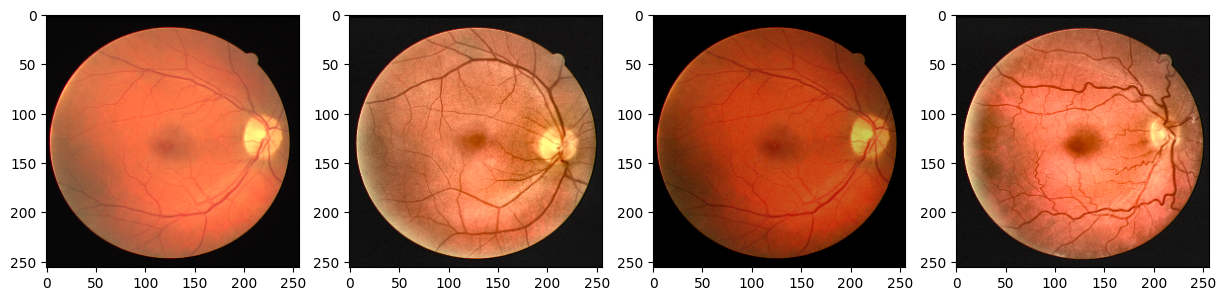

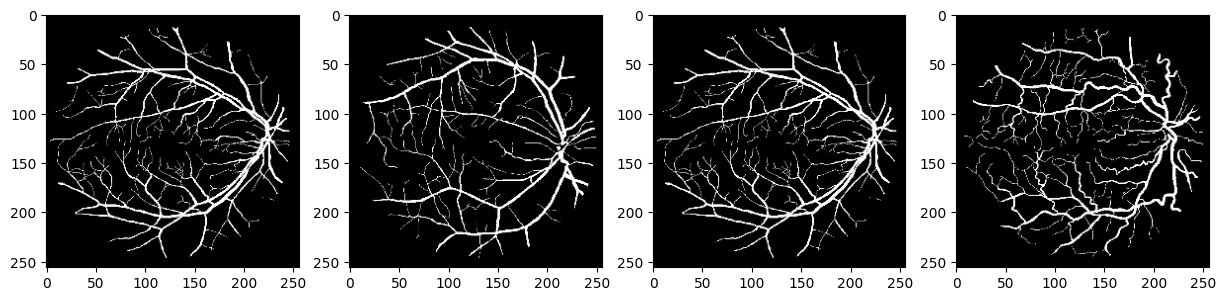

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[9]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[1]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[10]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[61]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[9]))
imgplot.set_clim(0.0, 1.4)

In [ ]:
#inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
#enet = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
#enet.summary()

In [ ]:
create_dir("files")
model_path = os.path.join("files", "DRIVE_UNET.hdf5")
csv_path = os.path.join("files", "DRIVE_UNET.csv")

In [ ]:
# Ref : https://github.com/bnsreenu/python_for_microscopists

def repeat_elem(tensor, rep):
  # lambda function to repeat Repeats the elements of a tensor along an axis
  #by a factor of rep.
  # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
  #(None, 256,256,6), if specified axis=3 and rep=2.

    return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                        arguments={'repnum': rep})(tensor)


In [ ]:
def attention_block(x, gating, inter_shape,):

  shape_x = K.int_shape(x)
  shape_g = K.int_shape(gating)

  # Initial gate
  theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='relu')(x)
  theta_x = MaxPooling2D((2,2))(theta_x)
  shape_theta_x = K.int_shape(theta_x)

  phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='relu')(gating)
  ##phi_g = Conv2DTranspose(inter_shape, kernel_size = 2, strides = 2, padding = 'same', kernel_initializer='he_normal')(phi_g)
  shape_phi_g = K.int_shape(phi_g)

  # Add components
  concat_xg = concatenate([phi_g, theta_x],axis = 3)
  # act_xg = Activation('relu')(concat_xg)

  # Apply convolution
  psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='relu')(concat_xg)

  # Apply sigmoid activation
  sigmoid_xg = Activation('relu')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  # UpSample and resample to correct size
  upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
  #upsample_psi = Conv2DTranspose(K.int_shape(sigmoid_xg)[3], 2, 2, kernel_initializer='he_normal')(sigmoid_xg)
  print(shape_x)
  #upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
  y = Multiply()([upsample_psi, x])
  ##y = Conv2D(K.int_shape(y)[3], 1, 1, kernel_initializer='he_normal')

  return y

In [ ]:
def squeeze_excite_block(inputs, ratio=16):
  init = inputs       ## (b, 128, 128, 32)
  channel_axis = -1
  filters = init.shape[channel_axis]
  se_shape = (1, 1, filters)

  se = GlobalAveragePooling2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
  se = Reshape(se_shape)(se)
  se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
  se = Dense(filters, activation="sigmoid", use_bias=False)(se)

  ret = Multiply()([inputs, se])
  return ret


In [ ]:
# def ResPath(filters, length, input):
#   shortcut = input
#   shortcut = conv2d_bn(shortcut, filters, activation=None, padding='same')

#   out = conv2d_bn(input, filters, activation='relu', padding='same')

#   out = add([shortcut, out])
#   out = Activation('relu')(out)
#   out = BatchNormalization(axis=3)(out)

#   for i in range(length-1):
#     shortcut = out
#     shortcut = conv2d_bn(shortcut, filters, activation=None, padding='same')

#     out = conv2d_bn(out, filters, activation='relu', padding='same')

#     out = add([shortcut, out])
#     out = Activation('relu')(out)
#     out = BatchNormalization(axis=3)(out)

#   return out

In [ ]:
def gated_cbam(input_tensor, reduction_ratio=16):
    """
    Adjusted CBAM module with residual connections and gated logic.

    Parameters:
        input_tensor: Input tensor to the CBAM module.
        reduction_ratio: Reduction ratio for channel attention.

    Returns:
        Output tensor after applying CBAM with gated logic and residual connections.
    """
    # Input shape and number of filters
    input_shape = input_tensor.shape
    filters = input_shape[-1]  # Number of channels

    # === Channel Attention ===
    # Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    # Global Max Pooling
    max_pool = GlobalMaxPooling2D()(input_tensor)

    # Shared Dense Layers for Gated Logic
    dense1 = Dense(filters // reduction_ratio, activation='relu', use_bias=False)
    dense2 = Dense(filters, activation='sigmoid', use_bias=False)

    avg_out = dense2(dense1(avg_pool))  # Average pooling path
    max_out = dense2(dense1(max_pool))  # Max pooling path

    # Gating logic: Multiply avg and max outputs
    channel_attention = Multiply()([avg_out, max_out])  # Element-wise gating
    channel_attention = Reshape((1, 1, filters))(channel_attention)

    # Residual connection for channel attention
    channel_refined = Multiply()([input_tensor, channel_attention])  # Element-wise multiplication
    channel_out = Add()([input_tensor, channel_refined])  # Add input and refined features

    # === Spatial Attention ===
    # Global pooling along the channel axis
    avg_pool_spatial = tf.reduce_mean(channel_out, axis=-1, keepdims=True)  # Average along channels
    max_pool_spatial = tf.reduce_max(channel_out, axis=-1, keepdims=True)  # Max along channels

    # Concatenate average and max pooling results
    spatial_concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    # Spatial attention with 7x7 convolution and gating
    spatial_attention = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(spatial_concat)
    spatial_refined = Multiply()([channel_out, spatial_attention])  # Element-wise multiplication

    # Residual connection for spatial attention
    spatial_out = Add()([channel_out, spatial_refined])  # Add input and refined features

    # === Output ===
    return spatial_out

In [ ]:
#Dense
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = AveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = MaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = UpSampling2D(size=(2, 2))(feats)
    con   = concatenate([x,feats])
    feats = Activation("sigmoid")(con)

    return feats

def spatial_attention_module(x,prev):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Concatenate()([feats,prev])
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    prev = x;
    x = channel_attention_module(x)
    x = spatial_attention_module(x,prev)
    return x

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add

def conv_block(inputs, out_ch, rate=1):
  x = Conv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
  """ Initial Conv """
  x = conv_block(inputs, out_ch)
  init_feats = x

  """ Encoder """
  skip = []
  x = conv_block(x, int_ch)
  skip.append(x)

  for i in range(num_layers-2):
      x = MaxPool2D((2, 2))(x)
      x = conv_block(x, int_ch)
      skip.append(x)

  """ Bridge """
  x = conv_block(x, int_ch, rate=rate)

  """ Decoder """
  skip.reverse()

  x = Concatenate()([x, skip[0]])
  x = conv_block(x, int_ch)

  for i in range(num_layers-3):
      x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
      x = Concatenate()([x, skip[i+1]])
      x = conv_block(x, int_ch)

  x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
  x = Concatenate()([x, skip[-1]])
  x = conv_block(x, out_ch)

  """ Add """
  x = Add()([x, init_feats])
  return x

def RSU_4F(inputs, out_ch, int_ch):
  """ Initial Conv """
  x0 = conv_block(inputs, out_ch, rate=1)

  """ Encoder """
  x1 = conv_block(x0, int_ch, rate=1)
  x2 = conv_block(x1, int_ch, rate=2)
  x3 = conv_block(x2, int_ch, rate=4)

  """ Bridge """
  x4 = conv_block(x3, int_ch, rate=8)

  """ Decoder """
  x = Concatenate()([x4, x3])
  x = conv_block(x, int_ch, rate=4)

  x = Concatenate()([x, x2])
  x = conv_block(x, int_ch, rate=2)

  x = Concatenate()([x, x1])
  x = conv_block(x, out_ch, rate=1)

  """ Addition """
  x = Add()([x, x0])
  return x

def u2net(input_shape, out_ch, int_ch, num_classes=1):
  """ Input Layer """
  inputs = Input(input_shape)
  s0 = inputs

  """ Encoder """
  s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
  # s1 = squeeze_excite_block(s1)
  s11 = cbam(s1)
  p1 = MaxPool2D((2, 2))(s11)

  s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
  s21 = cbam(s2)
  #s2 = squeeze_excite_block(s2)
  p2 = MaxPool2D((2, 2))(s21)

  s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
  s31 = cbam(s3)
  #s3 = squeeze_excite_block(s3)
  p3 = MaxPool2D((2, 2))(s31)

  s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
  s41 = cbam(s4)
  #s4 = squeeze_excite_block(s4)
  p4 = MaxPool2D((2, 2))(s41)

  s5 = RSU_4F(p4, out_ch[4], int_ch[4])
  s51 = cbam(s5)
  #s5 = squeeze_excite_block(s5)
  p5 = MaxPool2D((2, 2))(s51)

  """ Bridge """
  b1 = RSU_4F(p5, out_ch[5], int_ch[5])
  b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)


  """ Decoder """

  s5 = squeeze_excite_block(s5)
  d1 = Concatenate()([b2, s5])
  #d1 = squeeze_excite_block(d1)
  d1 = RSU_4F(d1, out_ch[6], int_ch[6])
  u1 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

  s4 = squeeze_excite_block(s4)
  d2 = Concatenate()([u1, s4])
  #d2 = squeeze_excite_block(d2)
  d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
  u2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

  s3 = squeeze_excite_block(s3)
  d3 = Concatenate()([u2, s3])
  #d3 = squeeze_excite_block(d3)
  d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
  u3 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

  s2 = squeeze_excite_block(s2)
  d4 = Concatenate()([u3, s2])
  #d4 = squeeze_excite_block(d4)
  d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
  u4 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

  s1 = squeeze_excite_block(s1)
  d5 = Concatenate()([u4, s1])
  #d5 = squeeze_excite_block(d5)
  d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)

  """ Side Outputs """
  y1 = Conv2D(num_classes, 3, padding="same")(d5)

  y2 = Conv2D(num_classes, 3, padding="same")(d4)
  y2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

  y3 = Conv2D(num_classes, 3, padding="same")(d3)
  y3 = UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

  y4 = Conv2D(num_classes, 3, padding="same")(d2)
  y4 = UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

  y5 = Conv2D(num_classes, 3, padding="same")(d1)
  y5 = UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

  y6 = Conv2D(num_classes, 3, padding="same")(b1)
  y6 = UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

  y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
  y0 = Conv2D(num_classes, 3, padding="same")(y0)

  y0 = Activation("sigmoid")(y0)


  #model = tf.keras.models.Model(inputs, outputs=[y0, y1, y2, y3, y4, y5, y6])
  model = tf.keras.models.Model(inputs, outputs= [y0])
  return model

def build_u2net(input_shape, num_classes=2):
  #out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
  out_ch = [32, 64, 128, 256, 256, 256, 256, 128, 64, 32, 32]
  int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
  model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
  return model

def build_u2net_lite(input_shape, num_classes=1):
  out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
  int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
  model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
  return model

if __name__ == "__main__":
  model = build_u2net((256, 256, 3))
  model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_124 (Conv2D)         (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_112 (B  (None, 256, 256, 32)         128       ['conv2d_124[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_118 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_11

In [ ]:
pip install segmentation_models

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy


smooth = 1e-15
def dice_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + smooth) / (union + smooth)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
  alpha=0.25
  gamma=2
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

  y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
  logits = tf.math.log(y_pred / (1 - y_pred))
  loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
  # or reduce_sum and/or axis=-1
  return tf.reduce_mean(loss)


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

opt = tf.keras.optimizers.Nadam(LR)
metrics = ['accuracy', dice_coef, Recall(), Precision(), iou, MeanIoU(num_classes=2)]
#model.compile(loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score], optimizer = opt)
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

callbacks = [
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
  CSVLogger(csv_path),
  EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False)]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
  train_steps += 1
if len(valid_x) % BATCH != 0:
  valid_steps += 1

hist=model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=EPOCHS,
  steps_per_epoch=train_steps,
  validation_steps=valid_steps,
  callbacks=callbacks
)

Epoch 1/100
84/84 [==============================] - 183s 388ms/step - loss: 0.7520 - accuracy: 0.6128 - dice_coef: 0.2480 - recall_1: 0.6018 - precision_1: 0.2581 - iou: 0.1419 - mean_io_u_1: 0.4793 - val_loss: 0.8591 - val_accuracy: 0.4753 - val_dice_coef: 0.1409 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_iou: 0.0758 - val_mean_io_u_1: 0.4798 - lr: 1.0000e-04
Epoch 2/100
84/84 [==============================] - 29s 348ms/step - loss: 0.6972 - accuracy: 0.5976 - dice_coef: 0.3028 - recall_1: 0.3600 - precision_1: 0.3535 - iou: 0.1789 - mean_io_u_1: 0.4797 - val_loss: 0.9271 - val_accuracy: 0.8973 - val_dice_coef: 0.0729 - val_recall_1: 0.0097 - val_precision_1: 0.4754 - val_iou: 0.0379 - val_mean_io_u_1: 0.4801 - lr: 1.0000e-04
Epoch 3/100
84/84 [==============================] - 29s 343ms/step - loss: 0.4875 - accuracy: 0.7052 - dice_coef: 0.5125 - recall_1: 0.3633 - precision_1: 0.7230 - iou: 0.3464 - mean_io_u_1: 0.4850 - val_loss: 0.9362 - val_accuracy: 0.9708 

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
  test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

11/11 [==============================] - 1s 83ms/step - loss: 0.1664 - accuracy: 0.9086 - dice_coef: 0.8336 - recall_1: 0.5582 - precision_1: 0.9719 - iou: 0.7159 - mean_io_u_1: 0.7631


[0.16643165051937103,
 0.908606767654419,
 0.8335683345794678,
 0.5582183599472046,
 0.9718592762947083,
 0.7159162163734436,
 0.763104259967804]

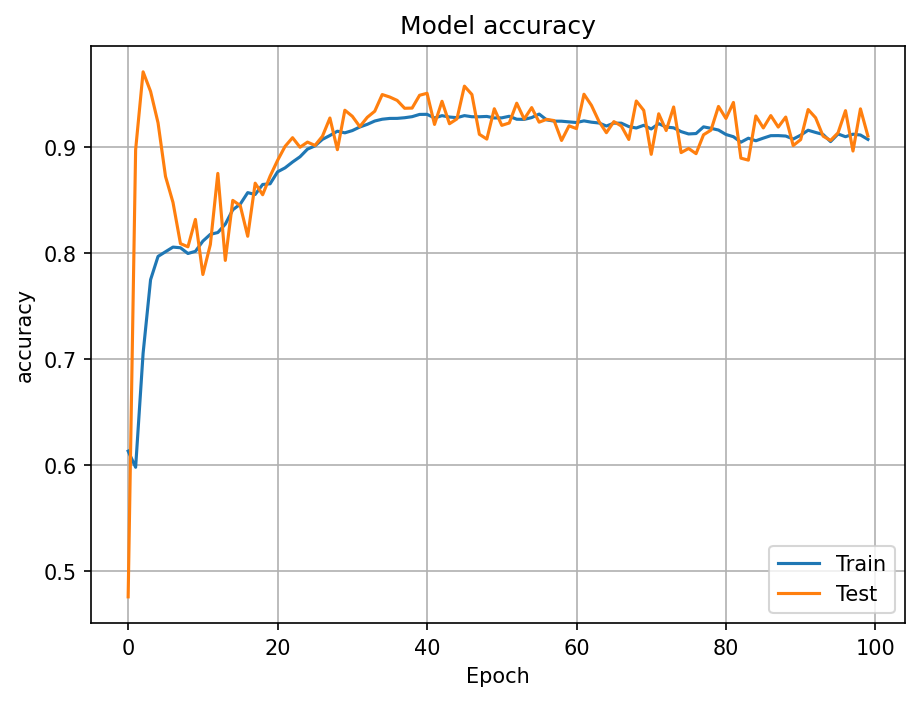

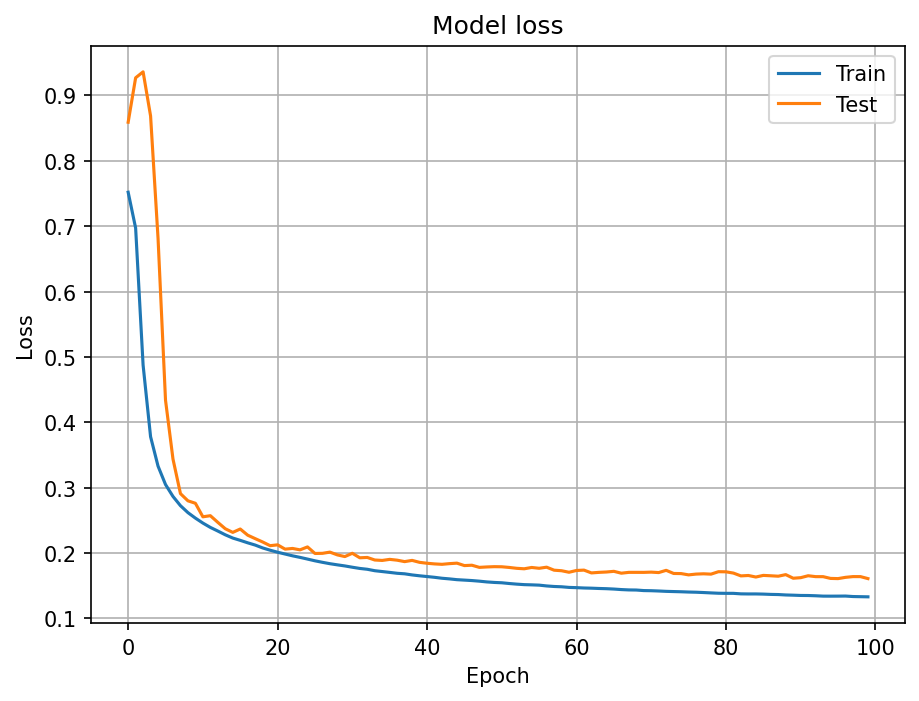

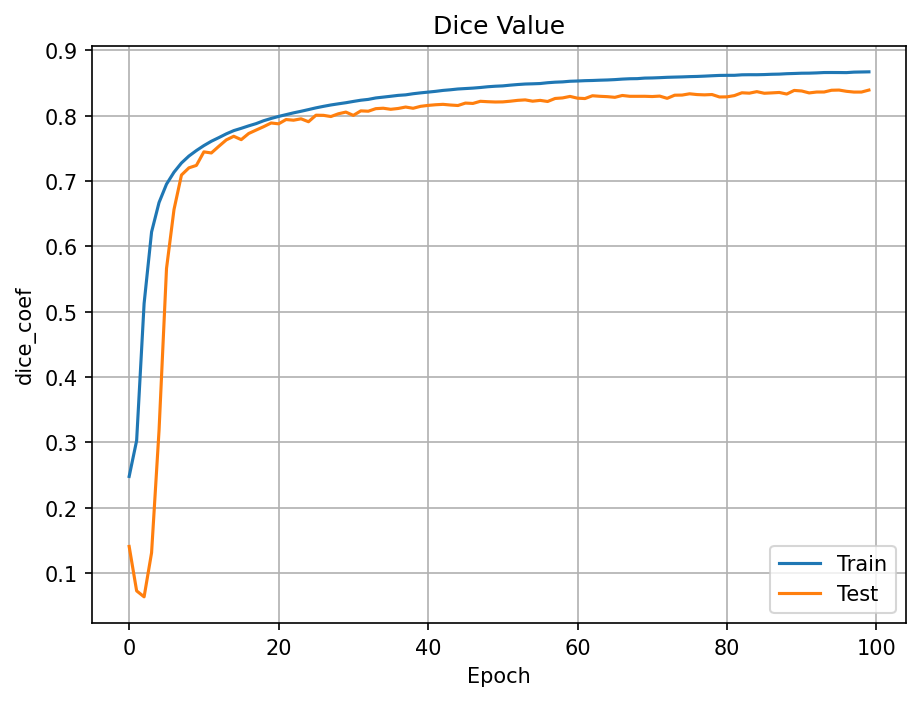

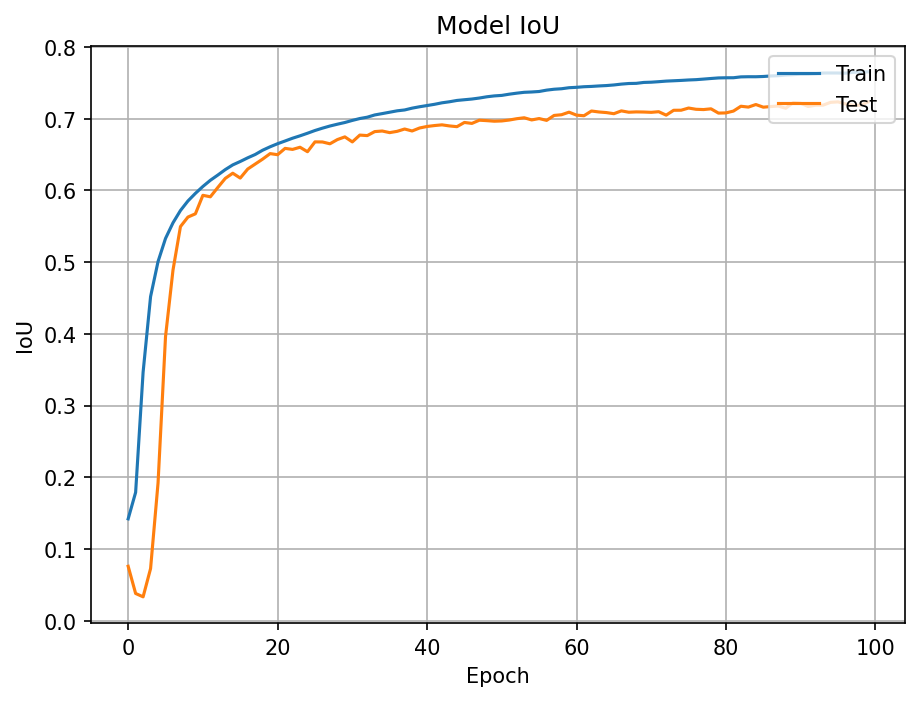

KeyError: 'mean_io_u'

<Figure size 1050x750 with 0 Axes>

In [ ]:
# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

# Plot training & validation accuracy values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Dice Value')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


# Plot training & validation loss values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['iou'])
plt.plot(hist.history['val_iou'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()


# Plot training & validation iou values
plt.rcParams['figure.dpi'] = 150
plt.figure(1,figsize=(7,5))
plt.plot(hist.history['mean_io_u'])
plt.plot(hist.history['val_mean_io_u'])
plt.title('Model mIoU')
plt.ylabel('mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid('on')
plt.show()


In [ ]:
# # New code # #

def read_image(x):
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  image = np.clip(image - np.median(image)+127, 0, 255)
  image = image/255.0
  image = image.astype(np.float32)
  image = np.expand_dims(image, axis=0)
  return image

def read_mask(y):
  mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  mask = mask.astype(np.float32)
  mask = mask/255.0
  mask = np.expand_dims(mask, axis=-1)
  return mask

def mask_to_3d(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

def parse(y_pred):
  y_pred = np.expand_dims(y_pred, axis=-1)
  y_pred = y_pred[..., -1]
  y_pred = y_pred.astype(np.float32)
  y_pred = np.expand_dims(y_pred, axis=-1)
  return y_pred


In [ ]:
import os
import numpy as np
import cv2
import json
from glob import glob
#from metrics import *
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
#from model import build_model, Upsample, ASPP

def create_dir(path):
  """ Create a directory. """
  try:
    if not os.path.exists(path):
      os.makedirs(path)
  except OSError:
    print(f"Error: creating directory with name {path}")

def read_data(x, y):
  """ Read the image and mask from the given path. """
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  mask = cv2.imread(y, cv2.IMREAD_COLOR)
  return image, mask

def read_params():
  """ Reading the parameters from the JSON file."""
  with open("params.json", "r") as f:
    data = f.read()
    params = json.loads(data)
    return params

def load_data(path):
  """ Loading the data from the given path. """
  images_path = os.path.join(path, "image/*")
  masks_path  = os.path.join(path, "mask/*")

  images = glob(images_path)
  masks  = glob(masks_path)

  return images, masks

def shuffling(x, y):
  x, y = shuffle(x, y, random_state=42)
  return x, y

def load_model_weight(path):
  with CustomObjectScope({
    'dice_loss': dice_loss,
    'dice_coef': dice_coef,
    'bce_dice_loss': bce_dice_loss,
    'focal_loss': focal_loss,
    'iou': iou
    }):
    model = load_model(path)
  return model
  # model = build_model(256)
  # model.load_weights(path)
  # return model

In [ ]:
model.save('/content/drive/MyDrive/Double Unet/Drive/DRIVE_UNET.hdf5')

In [ ]:
def create_dir(path):
  """ Create a directory. """
  try:
    if not os.path.exists(path):
      os.makedirs(path)
  except OSError:
    print(f"Error: creating directory with name {path}")

def evaluate_normal(model, x_data, y_data):
  THRESHOLD = 0.5
  total = []
  for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
    x = read_image(x)
    y = read_mask(y)
    _, h, w, _ = x.shape

    y_pred1 = parse(model.predict(x)[0][..., -2])
    y_pred2 = parse(model.predict(x)[0][..., -1])

    line = np.ones((h, 10, 3)) * 255.0

    all_images = [
      x[0] * 255.0, line,
      mask_to_3d(y) * 255.0, line,
      mask_to_3d(y_pred1) * 255.0, line,
      mask_to_3d(y_pred2) * 255.0
    ]
    mask = np.concatenate(all_images, axis=1)

    #cv2.imwrite(f"results/{i}.png", mask)
    cv2.imwrite(f"/content/drive/MyDrive/Double Unet/Drive/DRIVE_UNET_Results/{i}.png", mask)

smooth = 1.
def dice_coef(y_true, y_pred):
  y_true_f = tf.keras.layers.Flatten()(y_true)
  y_pred_f = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

if __name__ == "__main__":
  np.random.seed(42)
  tf.random.set_seed(42)
  #create_dir("results/")
  create_dir("/content/drive/MyDrive/Double Unet/Drive/DRIVE_UNET_Results/")

  batch_size = 4

  # test_path = "../1/new_data/test/"
  # test_x = sorted(glob(os.path.join(test_path, "image", "*.jpg")))
  # test_y = sorted(glob(os.path.join(test_path, "mask", "*.jpg")))
  test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

  test_steps = (len(test_x)//batch_size)
  if len(test_x) % batch_size != 0:
    test_steps += 1

  model = load_model_weight("/content/drive/MyDrive/Double Unet/Drive/DRIVE_UNET.hdf5")
  #model.evaluate(test_dataset, steps=test_steps)
  evaluate_normal(model, test_x, test_y)